In [5]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
from create_training_instance_dictionary_with_covariates import *
from feature_extraction import *
from sample_from_full_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [6]:
# Create training_instance_dict and extract features
##############################
# Load data and create a training_instance dictionary with covariates and M proteins only in the period of interest. 
DATA_CHOICE = "FISH_only"
M_number_of_measurements = 6
treat_id = 16
list_of_included_treatments = [treat_id] #[1,2,3,7,10,13,15,16]
patient_dictionary, training_instance_dict = create_training_instance_dictionary_with_covariates(minimum_number_of_measurements=M_number_of_measurements, global_treatment_id_list=list_of_included_treatments, verbose=False)
# Keep only patients that are in EHR data: 
COMMPASS_current_name_list = [elem[0] for elem in training_instance_dict.values()]
df_EHR = pd.read_excel('./COMMPASS_data/220615_commpass_clinical_genomic_annotated_EHR.xlsx')
EHR_name_list = [elem.replace("_1_BM" ,"", 1) for elem in df_EHR.loc[:,"sample"]]
NEW_TRAIN_ID = 0
new_patient_dictionary = {}
new_training_instance_dict = {}
for training_instance_id, patient in patient_dictionary.items(): # Dummy dictionary has training_instance_id as key
    this_name = COMMPASS_current_name_list[training_instance_id]
    if this_name in EHR_name_list: 
        new_patient_dictionary[NEW_TRAIN_ID] = patient_dictionary[training_instance_id] # equal to: "= patient"
        new_training_instance_dict[NEW_TRAIN_ID] = training_instance_dict[training_instance_id]
        NEW_TRAIN_ID = NEW_TRAIN_ID + 1
patient_dictionary = new_patient_dictionary
training_instance_dict = new_training_instance_dict

#for name, patient in patient_dictionary.items():
#    plot_true_mprotein_with_observations_and_treatments_and_estimate(Parameters(0.1, 0.1, 0.001, -0.001, 0, 0.1), patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(name), savename="./plots/Bayes_simulated_data/COMMPASS/"+str(name))

# Here we also reset so the time of first M protein measurement is at time zero! History is also made relative to that time. 
# And we also crop the history so that it stops at the last M protein measurement, since we are cropping the M protein lists. 
def standardize_Y_arrays(patient_dictionary):
    # standardize_input_from_dictionary
    y_pre_padding = np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]) #y_pre_padding = max(y_pre_padding,0)
    times_pre_padding = np.array([patient.measurement_times for _, patient in patient_dictionary.items()])
    # Reset time of "history" to match (history here is the acutal observed period)
    for ii, patient in patient_dictionary.items():
        patient.treatment_history = [Treatment(treat_i.start-times_pre_padding[ii][0], treat_i.end-times_pre_padding[ii][0], treat_i.id) for treat_i in patient.treatment_history]
        # This is incorrect/simplified for plotting: patient.treatment_history = [Treatment(patient.measurement_times[0], patient.measurement_times[-1], 0)]
    times_pre_padding = [t_list-t_list[0] for t_list in times_pre_padding]# Account for nonzero time 0
    len_y_each_patient = np.array([len(elem) for elem in times_pre_padding])
    max_len_y = max(len_y_each_patient)
    y = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    times = np.array([[np.nan for tt in range(max_len_y)] for ii in range(len(patient_dictionary))])
    for i in range(len(patient_dictionary)):
        for t in range(len_y_each_patient[i]):
            y[i][t] = y_pre_padding[i][t]
            times[i][t] = times_pre_padding[i][t]

    # Scale up Y to get it on a scale further away from zero
    y = 100*np.array([elem[0:M_number_of_measurements] for elem in y])
    times = np.array([elem[0:M_number_of_measurements] for elem in times])

    # y and times are cropped: Update the patient dictionary 
    cropped_dict = {}
    for training_instance_id in range(0, len(patient_dictionary)):
        cropped_dict[training_instance_id] = patient_dictionary[training_instance_id]
        cropped_dict[training_instance_id].measurement_times = times[training_instance_id]
        cropped_dict[training_instance_id].Mprotein_values = y[training_instance_id]

    # Crop "history": Treatments in interval of interest, to length of M protein history
    patient_id_and_treatment_index_list = []
    for ii, patient in cropped_dict.items():
        FOUND_LAST_RELEVANT_TREATMENT = False
        for index, treat_i in enumerate(patient.treatment_history):
            if not FOUND_LAST_RELEVANT_TREATMENT: # Only if we haven't found the end yet
                if treat_i.end > patient.measurement_times[-1]:
                    patient_id_and_treatment_index_list.append((ii, index))
                    FOUND_LAST_RELEVANT_TREATMENT = True
                    CROP_INDEX = index
                    print("Yahoo")
    for elem in patient_id_and_treatment_index_list: 
        ii, index = elem[0], elem[1]
        patient = cropped_dict[ii]
        print(ii, index)
        last_treatment_with_measurement = cropped_dict[ii].treatment_history[index]
        cropped_dict[ii].treatment_history[index] = Treatment(last_treatment_with_measurement.start, patient.measurement_times[-1], last_treatment_with_measurement.id)
        cropped_dict[ii].treatment_history = cropped_dict[ii].treatment_history[0:index+1]
    return cropped_dict

# X and patient_dictionary are passed on to the sampling
X = feature_extraction(training_instance_dict, DATA_CHOICE=DATA_CHOICE)
patient_dictionary = standardize_Y_arrays(patient_dictionary)
# Check that dimensions are correct
assert X.shape[0] == len(patient_dictionary)
N_cases, P = X.shape
print("N_cases:", N_cases)
print(patient_dictionary[0].treatment_history[-1].end)

Done finding 40 training instances with at least 6 M protein measurements.
30 cases in training_instance_dict
Adding clinical covariates and treatment as covariate
Number of clinical covariates including drug indicators: 14
Adding clinical covariates by EHR
How many from EHR not in current COMMPASS name list (due to inclusion criteria not being satisfied): 722
How many from current COMMPASS not in EHR name list: 0
How many overlapping: 30
Standardizing some features...
How many from FISH not in current COMMPASS name list (due to inclusion criteria not being satisfied): 1045
How many from current COMMPASS not in FISH name list: 0
How many overlapping (FISH/prev COMPASS): 30
Removing the homebrewed ones...
Any nan values in df_EHR? True
Any nan values in df_clinical_covariates? False
Any nan values in df_X_covariates? False
Missing data filled with naive means not per group
Total number of covariates in df_X: 164
   SeqWGS_Cp_10p14  SeqWGS_Cp_10q23  SeqWGS_Cp_11p15  SeqWGS_Cp_11q23  \
0 

In [7]:
print(patient_dictionary[0].treatment_history[-1].end)
print(patient_dictionary[0].measurement_times[-1])

448.0
448.0


RunningCOMMPASS_treat_id_16_M_6_P_164_N_cases_30_psi_prior_lognormal_N_samples_3000_N_tuning_3000_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_True
Max(Y): 620.0
Max(t): 1164.0


Sampling: [Y_obs, alpha, c2_pi_r, c2_rho_r, c2_rho_s, lam_pi_r, lam_rho_r, lam_rho_s, log_psi, omega, sigma_obs, tau_pi_r, tau_rho_r, tau_rho_s, theta_pi_r_offset, theta_rho_r_offset, theta_rho_s_offset, xi, z_pi_r, z_rho_r, z_rho_s]


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sigma_obs_log__`.ravel()[0] is NaN.
The current approximation of RV `alpha`.ravel()[0] is NaN.
The current approximation of RV `alpha`.ravel()[1] is NaN.
The current approximation of RV `alpha`.ravel()[2] is NaN.
The current approximation of RV `tau_rho_s_log__`.ravel()[0] is NaN.
The current approximation of RV `tau_rho_r_log__`.ravel()[0] is NaN.
The current approximation of RV `tau_pi_r_log__`.ravel()[0] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[0] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[1] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[2] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[3] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[4] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[5] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[6] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[7] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[8] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[9] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[10] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[11] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[12] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[13] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[14] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[15] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[16] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[17] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[18] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[19] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[20] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[21] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[22] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[23] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[24] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[25] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[26] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[27] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[28] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[29] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[30] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[31] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[32] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[33] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[34] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[35] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[36] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[37] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[38] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[39] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[40] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[41] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[42] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[43] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[44] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[45] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[46] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[47] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[48] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[49] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[50] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[51] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[52] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[53] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[54] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[55] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[56] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[57] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[58] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[59] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[60] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[61] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[62] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[63] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[64] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[65] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[66] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[67] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[68] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[69] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[70] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[71] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[72] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[73] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[74] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[75] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[76] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[77] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[78] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[79] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[80] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[81] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[82] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[83] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[84] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[85] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[86] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[87] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[88] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[89] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[90] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[91] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[92] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[93] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[94] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[95] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[96] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[97] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[98] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[99] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[100] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[101] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[102] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[103] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[104] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[105] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[106] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[107] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[108] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[109] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[110] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[111] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[112] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[113] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[114] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[115] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[116] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[117] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[118] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[119] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[120] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[121] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[122] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[123] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[124] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[125] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[126] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[127] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[128] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[129] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[130] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[131] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[132] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[133] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[134] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[135] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[136] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[137] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[138] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[139] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[140] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[141] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[142] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[143] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[144] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[145] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[146] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[147] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[148] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[149] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[150] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[151] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[152] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[153] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[154] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[155] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[156] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[157] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[158] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[159] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[160] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[161] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[162] is NaN.
The current approximation of RV `lam_rho_s_log__`.ravel()[163] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[0] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[1] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[2] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[3] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[4] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[5] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[6] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[7] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[8] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[9] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[10] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[11] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[12] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[13] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[14] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[15] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[16] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[17] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[18] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[19] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[20] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[21] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[22] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[23] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[24] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[25] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[26] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[27] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[28] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[29] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[30] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[31] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[32] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[33] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[34] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[35] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[36] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[37] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[38] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[39] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[40] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[41] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[42] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[43] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[44] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[45] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[46] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[47] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[48] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[49] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[50] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[51] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[52] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[53] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[54] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[55] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[56] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[57] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[58] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[59] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[60] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[61] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[62] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[63] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[64] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[65] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[66] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[67] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[68] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[69] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[70] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[71] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[72] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[73] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[74] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[75] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[76] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[77] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[78] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[79] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[80] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[81] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[82] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[83] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[84] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[85] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[86] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[87] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[88] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[89] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[90] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[91] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[92] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[93] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[94] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[95] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[96] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[97] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[98] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[99] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[100] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[101] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[102] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[103] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[104] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[105] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[106] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[107] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[108] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[109] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[110] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[111] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[112] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[113] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[114] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[115] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[116] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[117] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[118] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[119] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[120] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[121] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[122] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[123] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[124] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[125] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[126] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[127] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[128] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[129] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[130] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[131] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[132] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[133] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[134] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[135] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[136] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[137] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[138] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[139] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[140] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[141] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[142] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[143] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[144] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[145] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[146] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[147] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[148] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[149] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[150] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[151] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[152] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[153] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[154] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[155] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[156] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[157] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[158] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[159] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[160] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[161] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[162] is NaN.
The current approximation of RV `lam_rho_r_log__`.ravel()[163] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[0] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[1] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[2] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[3] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[4] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[5] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[6] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[7] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[8] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[9] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[10] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[11] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[12] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[13] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[14] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[15] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[16] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[17] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[18] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[19] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[20] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[21] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[22] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[23] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[24] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[25] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[26] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[27] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[28] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[29] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[30] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[31] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[32] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[33] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[34] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[35] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[36] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[37] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[38] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[39] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[40] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[41] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[42] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[43] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[44] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[45] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[46] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[47] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[48] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[49] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[50] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[51] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[52] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[53] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[54] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[55] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[56] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[57] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[58] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[59] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[60] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[61] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[62] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[63] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[64] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[65] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[66] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[67] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[68] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[69] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[70] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[71] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[72] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[73] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[74] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[75] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[76] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[77] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[78] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[79] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[80] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[81] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[82] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[83] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[84] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[85] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[86] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[87] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[88] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[89] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[90] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[91] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[92] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[93] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[94] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[95] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[96] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[97] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[98] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[99] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[100] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[101] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[102] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[103] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[104] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[105] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[106] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[107] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[108] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[109] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[110] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[111] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[112] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[113] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[114] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[115] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[116] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[117] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[118] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[119] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[120] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[121] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[122] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[123] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[124] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[125] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[126] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[127] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[128] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[129] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[130] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[131] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[132] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[133] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[134] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[135] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[136] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[137] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[138] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[139] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[140] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[141] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[142] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[143] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[144] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[145] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[146] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[147] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[148] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[149] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[150] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[151] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[152] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[153] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[154] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[155] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[156] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[157] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[158] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[159] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[160] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[161] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[162] is NaN.
The current approximation of RV `lam_pi_r_log__`.ravel()[163] is NaN.
The current approximation of RV `c2_rho_s_log__`.ravel()[0] is NaN.
The current approximation of RV `c2_rho_r_log__`.ravel()[0] is NaN.
The current approximation of RV `c2_pi_r_log__`.ravel()[0] is NaN.
The current approximation of RV `z_rho_s`.ravel()[0] is NaN.
The current approximation of RV `z_rho_s`.ravel()[1] is NaN.
The current approximation of RV `z_rho_s`.ravel()[2] is NaN.
The current approximation of RV `z_rho_s`.ravel()[3] is NaN.
The current approximation of RV `z_rho_s`.ravel()[4] is NaN.
The current approximation of RV `z_rho_s`.ravel()[5] is NaN.
The current approximation of RV `z_rho_s`.ravel()[6] is NaN.
The current approximation of RV `z_rho_s`.ravel()[7] is NaN.
The current approximation of RV `z_rho_s`.ravel()[8] is NaN.
The current approximation of RV `z_rho_s`.ravel()[9] is NaN.
The current approximation of RV `z_rho_s`.ravel()[10] is NaN.
The current approximation of RV `z_rho_s`.ravel()[11] is NaN.
The current approximation of RV `z_rho_s`.ravel()[12] is NaN.
The current approximation of RV `z_rho_s`.ravel()[13] is NaN.
The current approximation of RV `z_rho_s`.ravel()[14] is NaN.
The current approximation of RV `z_rho_s`.ravel()[15] is NaN.
The current approximation of RV `z_rho_s`.ravel()[16] is NaN.
The current approximation of RV `z_rho_s`.ravel()[17] is NaN.
The current approximation of RV `z_rho_s`.ravel()[18] is NaN.
The current approximation of RV `z_rho_s`.ravel()[19] is NaN.
The current approximation of RV `z_rho_s`.ravel()[20] is NaN.
The current approximation of RV `z_rho_s`.ravel()[21] is NaN.
The current approximation of RV `z_rho_s`.ravel()[22] is NaN.
The current approximation of RV `z_rho_s`.ravel()[23] is NaN.
The current approximation of RV `z_rho_s`.ravel()[24] is NaN.
The current approximation of RV `z_rho_s`.ravel()[25] is NaN.
The current approximation of RV `z_rho_s`.ravel()[26] is NaN.
The current approximation of RV `z_rho_s`.ravel()[27] is NaN.
The current approximation of RV `z_rho_s`.ravel()[28] is NaN.
The current approximation of RV `z_rho_s`.ravel()[29] is NaN.
The current approximation of RV `z_rho_s`.ravel()[30] is NaN.
The current approximation of RV `z_rho_s`.ravel()[31] is NaN.
The current approximation of RV `z_rho_s`.ravel()[32] is NaN.
The current approximation of RV `z_rho_s`.ravel()[33] is NaN.
The current approximation of RV `z_rho_s`.ravel()[34] is NaN.
The current approximation of RV `z_rho_s`.ravel()[35] is NaN.
The current approximation of RV `z_rho_s`.ravel()[36] is NaN.
The current approximation of RV `z_rho_s`.ravel()[37] is NaN.
The current approximation of RV `z_rho_s`.ravel()[38] is NaN.
The current approximation of RV `z_rho_s`.ravel()[39] is NaN.
The current approximation of RV `z_rho_s`.ravel()[40] is NaN.
The current approximation of RV `z_rho_s`.ravel()[41] is NaN.
The current approximation of RV `z_rho_s`.ravel()[42] is NaN.
The current approximation of RV `z_rho_s`.ravel()[43] is NaN.
The current approximation of RV `z_rho_s`.ravel()[44] is NaN.
The current approximation of RV `z_rho_s`.ravel()[45] is NaN.
The current approximation of RV `z_rho_s`.ravel()[46] is NaN.
The current approximation of RV `z_rho_s`.ravel()[47] is NaN.
The current approximation of RV `z_rho_s`.ravel()[48] is NaN.
The current approximation of RV `z_rho_s`.ravel()[49] is NaN.
The current approximation of RV `z_rho_s`.ravel()[50] is NaN.
The current approximation of RV `z_rho_s`.ravel()[51] is NaN.
The current approximation of RV `z_rho_s`.ravel()[52] is NaN.
The current approximation of RV `z_rho_s`.ravel()[53] is NaN.
The current approximation of RV `z_rho_s`.ravel()[54] is NaN.
The current approximation of RV `z_rho_s`.ravel()[55] is NaN.
The current approximation of RV `z_rho_s`.ravel()[56] is NaN.
The current approximation of RV `z_rho_s`.ravel()[57] is NaN.
The current approximation of RV `z_rho_s`.ravel()[58] is NaN.
The current approximation of RV `z_rho_s`.ravel()[59] is NaN.
The current approximation of RV `z_rho_s`.ravel()[60] is NaN.
The current approximation of RV `z_rho_s`.ravel()[61] is NaN.
The current approximation of RV `z_rho_s`.ravel()[62] is NaN.
The current approximation of RV `z_rho_s`.ravel()[63] is NaN.
The current approximation of RV `z_rho_s`.ravel()[64] is NaN.
The current approximation of RV `z_rho_s`.ravel()[65] is NaN.
The current approximation of RV `z_rho_s`.ravel()[66] is NaN.
The current approximation of RV `z_rho_s`.ravel()[67] is NaN.
The current approximation of RV `z_rho_s`.ravel()[68] is NaN.
The current approximation of RV `z_rho_s`.ravel()[69] is NaN.
The current approximation of RV `z_rho_s`.ravel()[70] is NaN.
The current approximation of RV `z_rho_s`.ravel()[71] is NaN.
The current approximation of RV `z_rho_s`.ravel()[72] is NaN.
The current approximation of RV `z_rho_s`.ravel()[73] is NaN.
The current approximation of RV `z_rho_s`.ravel()[74] is NaN.
The current approximation of RV `z_rho_s`.ravel()[75] is NaN.
The current approximation of RV `z_rho_s`.ravel()[76] is NaN.
The current approximation of RV `z_rho_s`.ravel()[77] is NaN.
The current approximation of RV `z_rho_s`.ravel()[78] is NaN.
The current approximation of RV `z_rho_s`.ravel()[79] is NaN.
The current approximation of RV `z_rho_s`.ravel()[80] is NaN.
The current approximation of RV `z_rho_s`.ravel()[81] is NaN.
The current approximation of RV `z_rho_s`.ravel()[82] is NaN.
The current approximation of RV `z_rho_s`.ravel()[83] is NaN.
The current approximation of RV `z_rho_s`.ravel()[84] is NaN.
The current approximation of RV `z_rho_s`.ravel()[85] is NaN.
The current approximation of RV `z_rho_s`.ravel()[86] is NaN.
The current approximation of RV `z_rho_s`.ravel()[87] is NaN.
The current approximation of RV `z_rho_s`.ravel()[88] is NaN.
The current approximation of RV `z_rho_s`.ravel()[89] is NaN.
The current approximation of RV `z_rho_s`.ravel()[90] is NaN.
The current approximation of RV `z_rho_s`.ravel()[91] is NaN.
The current approximation of RV `z_rho_s`.ravel()[92] is NaN.
The current approximation of RV `z_rho_s`.ravel()[93] is NaN.
The current approximation of RV `z_rho_s`.ravel()[94] is NaN.
The current approximation of RV `z_rho_s`.ravel()[95] is NaN.
The current approximation of RV `z_rho_s`.ravel()[96] is NaN.
The current approximation of RV `z_rho_s`.ravel()[97] is NaN.
The current approximation of RV `z_rho_s`.ravel()[98] is NaN.
The current approximation of RV `z_rho_s`.ravel()[99] is NaN.
The current approximation of RV `z_rho_s`.ravel()[100] is NaN.
The current approximation of RV `z_rho_s`.ravel()[101] is NaN.
The current approximation of RV `z_rho_s`.ravel()[102] is NaN.
The current approximation of RV `z_rho_s`.ravel()[103] is NaN.
The current approximation of RV `z_rho_s`.ravel()[104] is NaN.
The current approximation of RV `z_rho_s`.ravel()[105] is NaN.
The current approximation of RV `z_rho_s`.ravel()[106] is NaN.
The current approximation of RV `z_rho_s`.ravel()[107] is NaN.
The current approximation of RV `z_rho_s`.ravel()[108] is NaN.
The current approximation of RV `z_rho_s`.ravel()[109] is NaN.
The current approximation of RV `z_rho_s`.ravel()[110] is NaN.
The current approximation of RV `z_rho_s`.ravel()[111] is NaN.
The current approximation of RV `z_rho_s`.ravel()[112] is NaN.
The current approximation of RV `z_rho_s`.ravel()[113] is NaN.
The current approximation of RV `z_rho_s`.ravel()[114] is NaN.
The current approximation of RV `z_rho_s`.ravel()[115] is NaN.
The current approximation of RV `z_rho_s`.ravel()[116] is NaN.
The current approximation of RV `z_rho_s`.ravel()[117] is NaN.
The current approximation of RV `z_rho_s`.ravel()[118] is NaN.
The current approximation of RV `z_rho_s`.ravel()[119] is NaN.
The current approximation of RV `z_rho_s`.ravel()[120] is NaN.
The current approximation of RV `z_rho_s`.ravel()[121] is NaN.
The current approximation of RV `z_rho_s`.ravel()[122] is NaN.
The current approximation of RV `z_rho_s`.ravel()[123] is NaN.
The current approximation of RV `z_rho_s`.ravel()[124] is NaN.
The current approximation of RV `z_rho_s`.ravel()[125] is NaN.
The current approximation of RV `z_rho_s`.ravel()[126] is NaN.
The current approximation of RV `z_rho_s`.ravel()[127] is NaN.
The current approximation of RV `z_rho_s`.ravel()[128] is NaN.
The current approximation of RV `z_rho_s`.ravel()[129] is NaN.
The current approximation of RV `z_rho_s`.ravel()[130] is NaN.
The current approximation of RV `z_rho_s`.ravel()[131] is NaN.
The current approximation of RV `z_rho_s`.ravel()[132] is NaN.
The current approximation of RV `z_rho_s`.ravel()[133] is NaN.
The current approximation of RV `z_rho_s`.ravel()[134] is NaN.
The current approximation of RV `z_rho_s`.ravel()[135] is NaN.
The current approximation of RV `z_rho_s`.ravel()[136] is NaN.
The current approximation of RV `z_rho_s`.ravel()[137] is NaN.
The current approximation of RV `z_rho_s`.ravel()[138] is NaN.
The current approximation of RV `z_rho_s`.ravel()[139] is NaN.
The current approximation of RV `z_rho_s`.ravel()[140] is NaN.
The current approximation of RV `z_rho_s`.ravel()[141] is NaN.
The current approximation of RV `z_rho_s`.ravel()[142] is NaN.
The current approximation of RV `z_rho_s`.ravel()[143] is NaN.
The current approximation of RV `z_rho_s`.ravel()[144] is NaN.
The current approximation of RV `z_rho_s`.ravel()[145] is NaN.
The current approximation of RV `z_rho_s`.ravel()[146] is NaN.
The current approximation of RV `z_rho_s`.ravel()[147] is NaN.
The current approximation of RV `z_rho_s`.ravel()[148] is NaN.
The current approximation of RV `z_rho_s`.ravel()[149] is NaN.
The current approximation of RV `z_rho_s`.ravel()[150] is NaN.
The current approximation of RV `z_rho_s`.ravel()[151] is NaN.
The current approximation of RV `z_rho_s`.ravel()[152] is NaN.
The current approximation of RV `z_rho_s`.ravel()[153] is NaN.
The current approximation of RV `z_rho_s`.ravel()[154] is NaN.
The current approximation of RV `z_rho_s`.ravel()[155] is NaN.
The current approximation of RV `z_rho_s`.ravel()[156] is NaN.
The current approximation of RV `z_rho_s`.ravel()[157] is NaN.
The current approximation of RV `z_rho_s`.ravel()[158] is NaN.
The current approximation of RV `z_rho_s`.ravel()[159] is NaN.
The current approximation of RV `z_rho_s`.ravel()[160] is NaN.
The current approximation of RV `z_rho_s`.ravel()[161] is NaN.
The current approximation of RV `z_rho_s`.ravel()[162] is NaN.
The current approximation of RV `z_rho_s`.ravel()[163] is NaN.
The current approximation of RV `z_rho_r`.ravel()[0] is NaN.
The current approximation of RV `z_rho_r`.ravel()[1] is NaN.
The current approximation of RV `z_rho_r`.ravel()[2] is NaN.
The current approximation of RV `z_rho_r`.ravel()[3] is NaN.
The current approximation of RV `z_rho_r`.ravel()[4] is NaN.
The current approximation of RV `z_rho_r`.ravel()[5] is NaN.
The current approximation of RV `z_rho_r`.ravel()[6] is NaN.
The current approximation of RV `z_rho_r`.ravel()[7] is NaN.
The current approximation of RV `z_rho_r`.ravel()[8] is NaN.
The current approximation of RV `z_rho_r`.ravel()[9] is NaN.
The current approximation of RV `z_rho_r`.ravel()[10] is NaN.
The current approximation of RV `z_rho_r`.ravel()[11] is NaN.
The current approximation of RV `z_rho_r`.ravel()[12] is NaN.
The current approximation of RV `z_rho_r`.ravel()[13] is NaN.
The current approximation of RV `z_rho_r`.ravel()[14] is NaN.
The current approximation of RV `z_rho_r`.ravel()[15] is NaN.
The current approximation of RV `z_rho_r`.ravel()[16] is NaN.
The current approximation of RV `z_rho_r`.ravel()[17] is NaN.
The current approximation of RV `z_rho_r`.ravel()[18] is NaN.
The current approximation of RV `z_rho_r`.ravel()[19] is NaN.
The current approximation of RV `z_rho_r`.ravel()[20] is NaN.
The current approximation of RV `z_rho_r`.ravel()[21] is NaN.
The current approximation of RV `z_rho_r`.ravel()[22] is NaN.
The current approximation of RV `z_rho_r`.ravel()[23] is NaN.
The current approximation of RV `z_rho_r`.ravel()[24] is NaN.
The current approximation of RV `z_rho_r`.ravel()[25] is NaN.
The current approximation of RV `z_rho_r`.ravel()[26] is NaN.
The current approximation of RV `z_rho_r`.ravel()[27] is NaN.
The current approximation of RV `z_rho_r`.ravel()[28] is NaN.
The current approximation of RV `z_rho_r`.ravel()[29] is NaN.
The current approximation of RV `z_rho_r`.ravel()[30] is NaN.
The current approximation of RV `z_rho_r`.ravel()[31] is NaN.
The current approximation of RV `z_rho_r`.ravel()[32] is NaN.
The current approximation of RV `z_rho_r`.ravel()[33] is NaN.
The current approximation of RV `z_rho_r`.ravel()[34] is NaN.
The current approximation of RV `z_rho_r`.ravel()[35] is NaN.
The current approximation of RV `z_rho_r`.ravel()[36] is NaN.
The current approximation of RV `z_rho_r`.ravel()[37] is NaN.
The current approximation of RV `z_rho_r`.ravel()[38] is NaN.
The current approximation of RV `z_rho_r`.ravel()[39] is NaN.
The current approximation of RV `z_rho_r`.ravel()[40] is NaN.
The current approximation of RV `z_rho_r`.ravel()[41] is NaN.
The current approximation of RV `z_rho_r`.ravel()[42] is NaN.
The current approximation of RV `z_rho_r`.ravel()[43] is NaN.
The current approximation of RV `z_rho_r`.ravel()[44] is NaN.
The current approximation of RV `z_rho_r`.ravel()[45] is NaN.
The current approximation of RV `z_rho_r`.ravel()[46] is NaN.
The current approximation of RV `z_rho_r`.ravel()[47] is NaN.
The current approximation of RV `z_rho_r`.ravel()[48] is NaN.
The current approximation of RV `z_rho_r`.ravel()[49] is NaN.
The current approximation of RV `z_rho_r`.ravel()[50] is NaN.
The current approximation of RV `z_rho_r`.ravel()[51] is NaN.
The current approximation of RV `z_rho_r`.ravel()[52] is NaN.
The current approximation of RV `z_rho_r`.ravel()[53] is NaN.
The current approximation of RV `z_rho_r`.ravel()[54] is NaN.
The current approximation of RV `z_rho_r`.ravel()[55] is NaN.
The current approximation of RV `z_rho_r`.ravel()[56] is NaN.
The current approximation of RV `z_rho_r`.ravel()[57] is NaN.
The current approximation of RV `z_rho_r`.ravel()[58] is NaN.
The current approximation of RV `z_rho_r`.ravel()[59] is NaN.
The current approximation of RV `z_rho_r`.ravel()[60] is NaN.
The current approximation of RV `z_rho_r`.ravel()[61] is NaN.
The current approximation of RV `z_rho_r`.ravel()[62] is NaN.
The current approximation of RV `z_rho_r`.ravel()[63] is NaN.
The current approximation of RV `z_rho_r`.ravel()[64] is NaN.
The current approximation of RV `z_rho_r`.ravel()[65] is NaN.
The current approximation of RV `z_rho_r`.ravel()[66] is NaN.
The current approximation of RV `z_rho_r`.ravel()[67] is NaN.
The current approximation of RV `z_rho_r`.ravel()[68] is NaN.
The current approximation of RV `z_rho_r`.ravel()[69] is NaN.
The current approximation of RV `z_rho_r`.ravel()[70] is NaN.
The current approximation of RV `z_rho_r`.ravel()[71] is NaN.
The current approximation of RV `z_rho_r`.ravel()[72] is NaN.
The current approximation of RV `z_rho_r`.ravel()[73] is NaN.
The current approximation of RV `z_rho_r`.ravel()[74] is NaN.
The current approximation of RV `z_rho_r`.ravel()[75] is NaN.
The current approximation of RV `z_rho_r`.ravel()[76] is NaN.
The current approximation of RV `z_rho_r`.ravel()[77] is NaN.
The current approximation of RV `z_rho_r`.ravel()[78] is NaN.
The current approximation of RV `z_rho_r`.ravel()[79] is NaN.
The current approximation of RV `z_rho_r`.ravel()[80] is NaN.
The current approximation of RV `z_rho_r`.ravel()[81] is NaN.
The current approximation of RV `z_rho_r`.ravel()[82] is NaN.
The current approximation of RV `z_rho_r`.ravel()[83] is NaN.
The current approximation of RV `z_rho_r`.ravel()[84] is NaN.
The current approximation of RV `z_rho_r`.ravel()[85] is NaN.
The current approximation of RV `z_rho_r`.ravel()[86] is NaN.
The current approximation of RV `z_rho_r`.ravel()[87] is NaN.
The current approximation of RV `z_rho_r`.ravel()[88] is NaN.
The current approximation of RV `z_rho_r`.ravel()[89] is NaN.
The current approximation of RV `z_rho_r`.ravel()[90] is NaN.
The current approximation of RV `z_rho_r`.ravel()[91] is NaN.
The current approximation of RV `z_rho_r`.ravel()[92] is NaN.
The current approximation of RV `z_rho_r`.ravel()[93] is NaN.
The current approximation of RV `z_rho_r`.ravel()[94] is NaN.
The current approximation of RV `z_rho_r`.ravel()[95] is NaN.
The current approximation of RV `z_rho_r`.ravel()[96] is NaN.
The current approximation of RV `z_rho_r`.ravel()[97] is NaN.
The current approximation of RV `z_rho_r`.ravel()[98] is NaN.
The current approximation of RV `z_rho_r`.ravel()[99] is NaN.
The current approximation of RV `z_rho_r`.ravel()[100] is NaN.
The current approximation of RV `z_rho_r`.ravel()[101] is NaN.
The current approximation of RV `z_rho_r`.ravel()[102] is NaN.
The current approximation of RV `z_rho_r`.ravel()[103] is NaN.
The current approximation of RV `z_rho_r`.ravel()[104] is NaN.
The current approximation of RV `z_rho_r`.ravel()[105] is NaN.
The current approximation of RV `z_rho_r`.ravel()[106] is NaN.
The current approximation of RV `z_rho_r`.ravel()[107] is NaN.
The current approximation of RV `z_rho_r`.ravel()[108] is NaN.
The current approximation of RV `z_rho_r`.ravel()[109] is NaN.
The current approximation of RV `z_rho_r`.ravel()[110] is NaN.
The current approximation of RV `z_rho_r`.ravel()[111] is NaN.
The current approximation of RV `z_rho_r`.ravel()[112] is NaN.
The current approximation of RV `z_rho_r`.ravel()[113] is NaN.
The current approximation of RV `z_rho_r`.ravel()[114] is NaN.
The current approximation of RV `z_rho_r`.ravel()[115] is NaN.
The current approximation of RV `z_rho_r`.ravel()[116] is NaN.
The current approximation of RV `z_rho_r`.ravel()[117] is NaN.
The current approximation of RV `z_rho_r`.ravel()[118] is NaN.
The current approximation of RV `z_rho_r`.ravel()[119] is NaN.
The current approximation of RV `z_rho_r`.ravel()[120] is NaN.
The current approximation of RV `z_rho_r`.ravel()[121] is NaN.
The current approximation of RV `z_rho_r`.ravel()[122] is NaN.
The current approximation of RV `z_rho_r`.ravel()[123] is NaN.
The current approximation of RV `z_rho_r`.ravel()[124] is NaN.
The current approximation of RV `z_rho_r`.ravel()[125] is NaN.
The current approximation of RV `z_rho_r`.ravel()[126] is NaN.
The current approximation of RV `z_rho_r`.ravel()[127] is NaN.
The current approximation of RV `z_rho_r`.ravel()[128] is NaN.
The current approximation of RV `z_rho_r`.ravel()[129] is NaN.
The current approximation of RV `z_rho_r`.ravel()[130] is NaN.
The current approximation of RV `z_rho_r`.ravel()[131] is NaN.
The current approximation of RV `z_rho_r`.ravel()[132] is NaN.
The current approximation of RV `z_rho_r`.ravel()[133] is NaN.
The current approximation of RV `z_rho_r`.ravel()[134] is NaN.
The current approximation of RV `z_rho_r`.ravel()[135] is NaN.
The current approximation of RV `z_rho_r`.ravel()[136] is NaN.
The current approximation of RV `z_rho_r`.ravel()[137] is NaN.
The current approximation of RV `z_rho_r`.ravel()[138] is NaN.
The current approximation of RV `z_rho_r`.ravel()[139] is NaN.
The current approximation of RV `z_rho_r`.ravel()[140] is NaN.
The current approximation of RV `z_rho_r`.ravel()[141] is NaN.
The current approximation of RV `z_rho_r`.ravel()[142] is NaN.
The current approximation of RV `z_rho_r`.ravel()[143] is NaN.
The current approximation of RV `z_rho_r`.ravel()[144] is NaN.
The current approximation of RV `z_rho_r`.ravel()[145] is NaN.
The current approximation of RV `z_rho_r`.ravel()[146] is NaN.
The current approximation of RV `z_rho_r`.ravel()[147] is NaN.
The current approximation of RV `z_rho_r`.ravel()[148] is NaN.
The current approximation of RV `z_rho_r`.ravel()[149] is NaN.
The current approximation of RV `z_rho_r`.ravel()[150] is NaN.
The current approximation of RV `z_rho_r`.ravel()[151] is NaN.
The current approximation of RV `z_rho_r`.ravel()[152] is NaN.
The current approximation of RV `z_rho_r`.ravel()[153] is NaN.
The current approximation of RV `z_rho_r`.ravel()[154] is NaN.
The current approximation of RV `z_rho_r`.ravel()[155] is NaN.
The current approximation of RV `z_rho_r`.ravel()[156] is NaN.
The current approximation of RV `z_rho_r`.ravel()[157] is NaN.
The current approximation of RV `z_rho_r`.ravel()[158] is NaN.
The current approximation of RV `z_rho_r`.ravel()[159] is NaN.
The current approximation of RV `z_rho_r`.ravel()[160] is NaN.
The current approximation of RV `z_rho_r`.ravel()[161] is NaN.
The current approximation of RV `z_rho_r`.ravel()[162] is NaN.
The current approximation of RV `z_rho_r`.ravel()[163] is NaN.
The current approximation of RV `z_pi_r`.ravel()[0] is NaN.
The current approximation of RV `z_pi_r`.ravel()[1] is NaN.
The current approximation of RV `z_pi_r`.ravel()[2] is NaN.
The current approximation of RV `z_pi_r`.ravel()[3] is NaN.
The current approximation of RV `z_pi_r`.ravel()[4] is NaN.
The current approximation of RV `z_pi_r`.ravel()[5] is NaN.
The current approximation of RV `z_pi_r`.ravel()[6] is NaN.
The current approximation of RV `z_pi_r`.ravel()[7] is NaN.
The current approximation of RV `z_pi_r`.ravel()[8] is NaN.
The current approximation of RV `z_pi_r`.ravel()[9] is NaN.
The current approximation of RV `z_pi_r`.ravel()[10] is NaN.
The current approximation of RV `z_pi_r`.ravel()[11] is NaN.
The current approximation of RV `z_pi_r`.ravel()[12] is NaN.
The current approximation of RV `z_pi_r`.ravel()[13] is NaN.
The current approximation of RV `z_pi_r`.ravel()[14] is NaN.
The current approximation of RV `z_pi_r`.ravel()[15] is NaN.
The current approximation of RV `z_pi_r`.ravel()[16] is NaN.
The current approximation of RV `z_pi_r`.ravel()[17] is NaN.
The current approximation of RV `z_pi_r`.ravel()[18] is NaN.
The current approximation of RV `z_pi_r`.ravel()[19] is NaN.
The current approximation of RV `z_pi_r`.ravel()[20] is NaN.
The current approximation of RV `z_pi_r`.ravel()[21] is NaN.
The current approximation of RV `z_pi_r`.ravel()[22] is NaN.
The current approximation of RV `z_pi_r`.ravel()[23] is NaN.
The current approximation of RV `z_pi_r`.ravel()[24] is NaN.
The current approximation of RV `z_pi_r`.ravel()[25] is NaN.
The current approximation of RV `z_pi_r`.ravel()[26] is NaN.
The current approximation of RV `z_pi_r`.ravel()[27] is NaN.
The current approximation of RV `z_pi_r`.ravel()[28] is NaN.
The current approximation of RV `z_pi_r`.ravel()[29] is NaN.
The current approximation of RV `z_pi_r`.ravel()[30] is NaN.
The current approximation of RV `z_pi_r`.ravel()[31] is NaN.
The current approximation of RV `z_pi_r`.ravel()[32] is NaN.
The current approximation of RV `z_pi_r`.ravel()[33] is NaN.
The current approximation of RV `z_pi_r`.ravel()[34] is NaN.
The current approximation of RV `z_pi_r`.ravel()[35] is NaN.
The current approximation of RV `z_pi_r`.ravel()[36] is NaN.
The current approximation of RV `z_pi_r`.ravel()[37] is NaN.
The current approximation of RV `z_pi_r`.ravel()[38] is NaN.
The current approximation of RV `z_pi_r`.ravel()[39] is NaN.
The current approximation of RV `z_pi_r`.ravel()[40] is NaN.
The current approximation of RV `z_pi_r`.ravel()[41] is NaN.
The current approximation of RV `z_pi_r`.ravel()[42] is NaN.
The current approximation of RV `z_pi_r`.ravel()[43] is NaN.
The current approximation of RV `z_pi_r`.ravel()[44] is NaN.
The current approximation of RV `z_pi_r`.ravel()[45] is NaN.
The current approximation of RV `z_pi_r`.ravel()[46] is NaN.
The current approximation of RV `z_pi_r`.ravel()[47] is NaN.
The current approximation of RV `z_pi_r`.ravel()[48] is NaN.
The current approximation of RV `z_pi_r`.ravel()[49] is NaN.
The current approximation of RV `z_pi_r`.ravel()[50] is NaN.
The current approximation of RV `z_pi_r`.ravel()[51] is NaN.
The current approximation of RV `z_pi_r`.ravel()[52] is NaN.
The current approximation of RV `z_pi_r`.ravel()[53] is NaN.
The current approximation of RV `z_pi_r`.ravel()[54] is NaN.
The current approximation of RV `z_pi_r`.ravel()[55] is NaN.
The current approximation of RV `z_pi_r`.ravel()[56] is NaN.
The current approximation of RV `z_pi_r`.ravel()[57] is NaN.
The current approximation of RV `z_pi_r`.ravel()[58] is NaN.
The current approximation of RV `z_pi_r`.ravel()[59] is NaN.
The current approximation of RV `z_pi_r`.ravel()[60] is NaN.
The current approximation of RV `z_pi_r`.ravel()[61] is NaN.
The current approximation of RV `z_pi_r`.ravel()[62] is NaN.
The current approximation of RV `z_pi_r`.ravel()[63] is NaN.
The current approximation of RV `z_pi_r`.ravel()[64] is NaN.
The current approximation of RV `z_pi_r`.ravel()[65] is NaN.
The current approximation of RV `z_pi_r`.ravel()[66] is NaN.
The current approximation of RV `z_pi_r`.ravel()[67] is NaN.
The current approximation of RV `z_pi_r`.ravel()[68] is NaN.
The current approximation of RV `z_pi_r`.ravel()[69] is NaN.
The current approximation of RV `z_pi_r`.ravel()[70] is NaN.
The current approximation of RV `z_pi_r`.ravel()[71] is NaN.
The current approximation of RV `z_pi_r`.ravel()[72] is NaN.
The current approximation of RV `z_pi_r`.ravel()[73] is NaN.
The current approximation of RV `z_pi_r`.ravel()[74] is NaN.
The current approximation of RV `z_pi_r`.ravel()[75] is NaN.
The current approximation of RV `z_pi_r`.ravel()[76] is NaN.
The current approximation of RV `z_pi_r`.ravel()[77] is NaN.
The current approximation of RV `z_pi_r`.ravel()[78] is NaN.
The current approximation of RV `z_pi_r`.ravel()[79] is NaN.
The current approximation of RV `z_pi_r`.ravel()[80] is NaN.
The current approximation of RV `z_pi_r`.ravel()[81] is NaN.
The current approximation of RV `z_pi_r`.ravel()[82] is NaN.
The current approximation of RV `z_pi_r`.ravel()[83] is NaN.
The current approximation of RV `z_pi_r`.ravel()[84] is NaN.
The current approximation of RV `z_pi_r`.ravel()[85] is NaN.
The current approximation of RV `z_pi_r`.ravel()[86] is NaN.
The current approximation of RV `z_pi_r`.ravel()[87] is NaN.
The current approximation of RV `z_pi_r`.ravel()[88] is NaN.
The current approximation of RV `z_pi_r`.ravel()[89] is NaN.
The current approximation of RV `z_pi_r`.ravel()[90] is NaN.
The current approximation of RV `z_pi_r`.ravel()[91] is NaN.
The current approximation of RV `z_pi_r`.ravel()[92] is NaN.
The current approximation of RV `z_pi_r`.ravel()[93] is NaN.
The current approximation of RV `z_pi_r`.ravel()[94] is NaN.
The current approximation of RV `z_pi_r`.ravel()[95] is NaN.
The current approximation of RV `z_pi_r`.ravel()[96] is NaN.
The current approximation of RV `z_pi_r`.ravel()[97] is NaN.
The current approximation of RV `z_pi_r`.ravel()[98] is NaN.
The current approximation of RV `z_pi_r`.ravel()[99] is NaN.
The current approximation of RV `z_pi_r`.ravel()[100] is NaN.
The current approximation of RV `z_pi_r`.ravel()[101] is NaN.
The current approximation of RV `z_pi_r`.ravel()[102] is NaN.
The current approximation of RV `z_pi_r`.ravel()[103] is NaN.
The current approximation of RV `z_pi_r`.ravel()[104] is NaN.
The current approximation of RV `z_pi_r`.ravel()[105] is NaN.
The current approximation of RV `z_pi_r`.ravel()[106] is NaN.
The current approximation of RV `z_pi_r`.ravel()[107] is NaN.
The current approximation of RV `z_pi_r`.ravel()[108] is NaN.
The current approximation of RV `z_pi_r`.ravel()[109] is NaN.
The current approximation of RV `z_pi_r`.ravel()[110] is NaN.
The current approximation of RV `z_pi_r`.ravel()[111] is NaN.
The current approximation of RV `z_pi_r`.ravel()[112] is NaN.
The current approximation of RV `z_pi_r`.ravel()[113] is NaN.
The current approximation of RV `z_pi_r`.ravel()[114] is NaN.
The current approximation of RV `z_pi_r`.ravel()[115] is NaN.
The current approximation of RV `z_pi_r`.ravel()[116] is NaN.
The current approximation of RV `z_pi_r`.ravel()[117] is NaN.
The current approximation of RV `z_pi_r`.ravel()[118] is NaN.
The current approximation of RV `z_pi_r`.ravel()[119] is NaN.
The current approximation of RV `z_pi_r`.ravel()[120] is NaN.
The current approximation of RV `z_pi_r`.ravel()[121] is NaN.
The current approximation of RV `z_pi_r`.ravel()[122] is NaN.
The current approximation of RV `z_pi_r`.ravel()[123] is NaN.
The current approximation of RV `z_pi_r`.ravel()[124] is NaN.
The current approximation of RV `z_pi_r`.ravel()[125] is NaN.
The current approximation of RV `z_pi_r`.ravel()[126] is NaN.
The current approximation of RV `z_pi_r`.ravel()[127] is NaN.
The current approximation of RV `z_pi_r`.ravel()[128] is NaN.
The current approximation of RV `z_pi_r`.ravel()[129] is NaN.
The current approximation of RV `z_pi_r`.ravel()[130] is NaN.
The current approximation of RV `z_pi_r`.ravel()[131] is NaN.
The current approximation of RV `z_pi_r`.ravel()[132] is NaN.
The current approximation of RV `z_pi_r`.ravel()[133] is NaN.
The current approximation of RV `z_pi_r`.ravel()[134] is NaN.
The current approximation of RV `z_pi_r`.ravel()[135] is NaN.
The current approximation of RV `z_pi_r`.ravel()[136] is NaN.
The current approximation of RV `z_pi_r`.ravel()[137] is NaN.
The current approximation of RV `z_pi_r`.ravel()[138] is NaN.
The current approximation of RV `z_pi_r`.ravel()[139] is NaN.
The current approximation of RV `z_pi_r`.ravel()[140] is NaN.
The current approximation of RV `z_pi_r`.ravel()[141] is NaN.
The current approximation of RV `z_pi_r`.ravel()[142] is NaN.
The current approximation of RV `z_pi_r`.ravel()[143] is NaN.
The current approximation of RV `z_pi_r`.ravel()[144] is NaN.
The current approximation of RV `z_pi_r`.ravel()[145] is NaN.
The current approximation of RV `z_pi_r`.ravel()[146] is NaN.
The current approximation of RV `z_pi_r`.ravel()[147] is NaN.
The current approximation of RV `z_pi_r`.ravel()[148] is NaN.
The current approximation of RV `z_pi_r`.ravel()[149] is NaN.
The current approximation of RV `z_pi_r`.ravel()[150] is NaN.
The current approximation of RV `z_pi_r`.ravel()[151] is NaN.
The current approximation of RV `z_pi_r`.ravel()[152] is NaN.
The current approximation of RV `z_pi_r`.ravel()[153] is NaN.
The current approximation of RV `z_pi_r`.ravel()[154] is NaN.
The current approximation of RV `z_pi_r`.ravel()[155] is NaN.
The current approximation of RV `z_pi_r`.ravel()[156] is NaN.
The current approximation of RV `z_pi_r`.ravel()[157] is NaN.
The current approximation of RV `z_pi_r`.ravel()[158] is NaN.
The current approximation of RV `z_pi_r`.ravel()[159] is NaN.
The current approximation of RV `z_pi_r`.ravel()[160] is NaN.
The current approximation of RV `z_pi_r`.ravel()[161] is NaN.
The current approximation of RV `z_pi_r`.ravel()[162] is NaN.
The current approximation of RV `z_pi_r`.ravel()[163] is NaN.
The current approximation of RV `omega_log__`.ravel()[0] is NaN.
The current approximation of RV `omega_log__`.ravel()[1] is NaN.
The current approximation of RV `omega_log__`.ravel()[2] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[0] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[1] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[2] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[3] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[4] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[5] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[6] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[7] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[8] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[9] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[10] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[11] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[12] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[13] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[14] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[15] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[16] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[17] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[18] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[19] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[20] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[21] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[22] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[23] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[24] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[25] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[26] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[27] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[28] is NaN.
The current approximation of RV `theta_rho_s_offset`.ravel()[29] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[0] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[1] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[2] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[3] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[4] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[5] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[6] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[7] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[8] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[9] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[10] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[11] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[12] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[13] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[14] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[15] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[16] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[17] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[18] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[19] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[20] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[21] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[22] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[23] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[24] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[25] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[26] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[27] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[28] is NaN.
The current approximation of RV `theta_rho_r_offset`.ravel()[29] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[0] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[1] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[2] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[3] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[4] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[5] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[6] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[7] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[8] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[9] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[10] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[11] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[12] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[13] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[14] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[15] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[16] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[17] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[18] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[19] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[20] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[21] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[22] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[23] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[24] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[25] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[26] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[27] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[28] is NaN.
The current approximation of RV `theta_pi_r_offset`.ravel()[29] is NaN.
The current approximation of RV `xi_log__`.ravel()[0] is NaN.
The current approximation of RV `log_psi`.ravel()[0] is NaN.
The current approximation of RV `log_psi`.ravel()[1] is NaN.
The current approximation of RV `log_psi`.ravel()[2] is NaN.
The current approximation of RV `log_psi`.ravel()[3] is NaN.
The current approximation of RV `log_psi`.ravel()[4] is NaN.
The current approximation of RV `log_psi`.ravel()[5] is NaN.
The current approximation of RV `log_psi`.ravel()[6] is NaN.
The current approximation of RV `log_psi`.ravel()[7] is NaN.
The current approximation of RV `log_psi`.ravel()[8] is NaN.
The current approximation of RV `log_psi`.ravel()[9] is NaN.
The current approximation of RV `log_psi`.ravel()[10] is NaN.
The current approximation of RV `log_psi`.ravel()[11] is NaN.
The current approximation of RV `log_psi`.ravel()[12] is NaN.
The current approximation of RV `log_psi`.ravel()[13] is NaN.
The current approximation of RV `log_psi`.ravel()[14] is NaN.
The current approximation of RV `log_psi`.ravel()[15] is NaN.
The current approximation of RV `log_psi`.ravel()[16] is NaN.
The current approximation of RV `log_psi`.ravel()[17] is NaN.
The current approximation of RV `log_psi`.ravel()[18] is NaN.
The current approximation of RV `log_psi`.ravel()[19] is NaN.
The current approximation of RV `log_psi`.ravel()[20] is NaN.
The current approximation of RV `log_psi`.ravel()[21] is NaN.
The current approximation of RV `log_psi`.ravel()[22] is NaN.
The current approximation of RV `log_psi`.ravel()[23] is NaN.
The current approximation of RV `log_psi`.ravel()[24] is NaN.
The current approximation of RV `log_psi`.ravel()[25] is NaN.
The current approximation of RV `log_psi`.ravel()[26] is NaN.
The current approximation of RV `log_psi`.ravel()[27] is NaN.
The current approximation of RV `log_psi`.ravel()[28] is NaN.
The current approximation of RV `log_psi`.ravel()[29] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

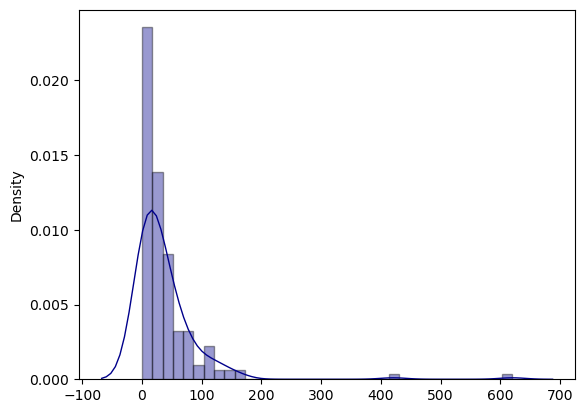

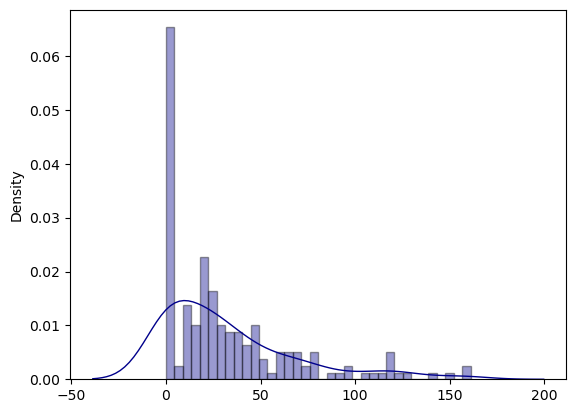

In [8]:
# Sample from full model
psi_prior="lognormal"
N_samples = 3000
N_tuning = 3000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = True
name = "COMMPASS_treat_id_"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running"+name)
idata = sample_from_full_model(X, patient_dictionary, name, N_samples=N_samples, N_tuning=N_tuning, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION, method="ADVI")
# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [ ]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

In [ ]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
az.plot_autocorr(idata, var_names=["alpha"]);
az.plot_autocorr(idata, var_names=["beta_rho_s"]);
az.plot_autocorr(idata, var_names=["beta_rho_r"]);
az.plot_autocorr(idata, var_names=["beta_pi_r"]);
az.plot_autocorr(idata, var_names=["omega"]);
az.plot_autocorr(idata, var_names=["sigma_obs"]);

In [ ]:
# Posterior means 
print("List of covariates:", idata.posterior.coords['predictors'])
print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
print('\nPosterior average of beta_rho_s:\n', np.mean(idata.posterior['beta_rho_s'], axis=(0,1)))
print('\nPosterior average of beta_rho_r:\n', np.mean(idata.posterior['beta_rho_r'], axis=(0,1)))
print('\nPosterior average of beta_pi_r:\n', np.mean(idata.posterior['beta_pi_r'], axis=(0,1)))
print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

In [ ]:
az.plot_trace(idata, var_names=('alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_s'), lines=[('beta_rho_s', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_s.png")
# There seems to be an effect where Age contributes towards higher growth rate for sensitive cells

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_r'), lines=[('beta_rho_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_r.png")

In [ ]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_pi_r'), lines=[('beta_pi_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.

In [ ]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
az.plot_energy(idata)
plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["beta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["beta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["beta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_pi_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [ ]:
# Posterior distribution of y values
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2]
# Gather all the parameter estimates and get y values for each parameter set
posterior_parameters = np.empty(shape=sample_shape, dtype=object)
y_resolution = 1000
predicted_y_values = np.empty((sample_shape+(y_resolution,)))
predicted_y_resistant_values = np.empty_like(predicted_y_values)
for ii in range(var_dimensions): # per patient
    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times()
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa,ii] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa,ii]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            meas = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            predicted_y_values[ch,sa,ii] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa,ii] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)


In [ ]:
print(predicted_y_values[0,0,0].shape)
print(predicted_y_resistant_values[0,0,0].shape)

# Group measurements by patient and time
flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,var_dimensions,1000))
# sort the arrays of y
sorted_pred_y_values = np.sort(flat_pred_y_values, axis=0)
print(sorted_pred_y_values.shape)

In [ ]:
# Plot posterior confidence intervals 
for training_instance_id, patient in patient_dictionary.items():
    savename = "./plots/Bayesian_estimates/CI_training_id_"+str(training_instance_id)+"_treat_id_"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+".png"
    plot_posterior_confidence_intervals(training_instance_id, patient, sorted_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior CI for patient "+str(training_instance_id), savename=savename, y_resolution=y_resolution)

In [ ]:
# Posterior median M protein 
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print("Median sigma_obs:", median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print("First patient's median parameters:", estimated_parameters_dict[0].to_array_with_sigma())

# Plot patient estimates
for training_instance_id, patient in patient_dictionary.items():
    estimated_parameters = estimated_parameters_dict[training_instance_id]
    #patient.print()
    savename = "./plots/Bayesian_estimates/training_id_"+str(training_instance_id)+"_data_"+DATA_CHOICE+"_treat_id"+str(treat_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_median_parameters__Y_0="+str(estimated_parameters.Y_0)+", pi_r="+str(estimated_parameters.pi_r)+", g_r="+str(estimated_parameters.g_r)+", g_s="+str(estimated_parameters.g_s)+", k_1="+str(estimated_parameters.k_1)+", sigma="+str(estimated_parameters.sigma)+".png"
    plot_treatment_region_with_estimate(estimated_parameters, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Posterior median for "+str(training_instance_id), savename=savename)
